# Clustering the brazilian E-commerce public dataset

# Summary:
1. About Dataset
2. Loading libraries and data
3. EDA
4. Preprocessing
5. Clustering

# 1. About Dataset

Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

# Context

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

# Attention

- An order might have multiple items.
- Each item might be fulfilled by a distinct seller.
- All text identifying stores and partners where replaced by the names of Game of Thrones great houses.

# Data Schema

The data is divided in multiple datasets for better understanding and organization. 

Please refer to the following data schema when working with it:

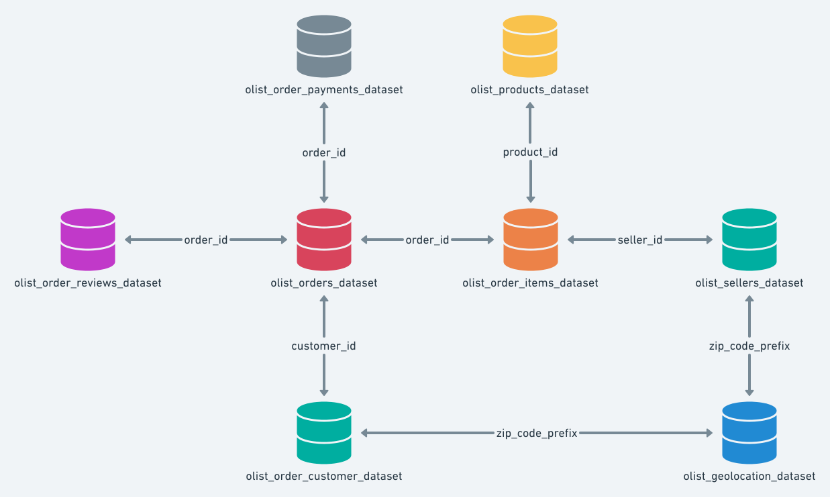

# 2. Loading libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
from dython.nominal import associations
from IPython.display import display
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set_style("whitegrid", {"axes.grid" : True, "axes.edgecolor":"black"})
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None 

Im going to use the data frames:
- Customer.
- Order item.
- Order payments.
- Orders.
- Products.
- Sellers.
- Product category.

In [2]:
def load_data():
    #customer dataset
    df_customer = pd.read_csv("/Users/agustintumminello/Desktop/archive (35)/olist_customers_dataset.csv")
    #order item dataset
    df_order_item = pd.read_csv("/Users/agustintumminello/Desktop/archive (35)/olist_order_items_dataset.csv")
    #order payments dataset
    df_order_payments = pd.read_csv("/Users/agustintumminello/Desktop/archive (35)/olist_order_payments_dataset.csv")
    #orders dataset
    df_orders = pd.read_csv("/Users/agustintumminello/Desktop/archive (35)/olist_orders_dataset.csv")
    #products dataset
    df_products = pd.read_csv("/Users/agustintumminello/Desktop/archive (35)/olist_products_dataset.csv")
    #sellers dataset
    df_sellers = pd.read_csv("/Users/agustintumminello/Desktop/archive (35)/olist_sellers_dataset.csv")
    #product category dataset
    df_product_category = pd.read_csv("/Users/agustintumminello/Desktop/archive (35)/product_category_name_translation.csv")
    #final df
    df = df_customer.merge(df_orders, on="customer_id") \
                 .merge(df_order_item, on="order_id") \
                 .merge(df_order_payments, on="order_id") \
                 .merge(df_products, on="product_id") \
                 .merge(df_product_category, on="product_category_name") \
                 .merge(df_sellers, on="seller_id")
    return df

df = load_data()

# 3. EDA

In [3]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,1,credit_card,1,275.79,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,1,credit_card,1,275.79,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:56,124.99,15.62,1,credit_card,7,140.61,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,106.99,30.59,1,credit_card,10,137.58,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP


In [4]:
display(f"The dataset has {df.shape[0]} rows") 
display(f"The dataset has {df.shape[1]} columns")

'The dataset has 115878 rows'

'The dataset has 34 columns'

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115878 entries, 0 to 115877
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    115878 non-null  object 
 1   customer_unique_id             115878 non-null  object 
 2   customer_zip_code_prefix       115878 non-null  int64  
 3   customer_city                  115878 non-null  object 
 4   customer_state                 115878 non-null  object 
 5   order_id                       115878 non-null  object 
 6   order_status                   115878 non-null  object 
 7   order_purchase_timestamp       115878 non-null  object 
 8   order_approved_at              115864 non-null  object 
 9   order_delivered_carrier_date   114673 non-null  object 
 10  order_delivered_customer_date  113383 non-null  object 
 11  order_estimated_delivery_date  115878 non-null  object 
 12  order_item_id                 

# Null values

In [6]:
(df
 .isnull()
 .mean()
 .sort_values(ascending=False)
 .to_frame("% Null values"))

,% Null values
order_delivered_customer_date,0.021531
order_delivered_carrier_date,0.010399
order_approved_at,0.000121
product_width_cm,0.000009
product_height_cm,0.000009
product_length_cm,0.000009
product_weight_g,0.000009
product_photos_qty,0.000000
payment_value,0.000000
product_category_name,0.000000


In [7]:
#the dataset has 7 columns with null values, lets analyze it better.
columns_with_null_values = ["order_approved_at",
                            "order_delivered_carrier_date",
                            "order_delivered_customer_date",
                            "product_weight_g",
                            "product_length_cm",
                            "product_height_cm",
                            "product_width_cm"]

null = df[df.isnull().any(axis=1)]
#null.style to check the null values in context.
#or query.

Some orders are not finalized, some are not even approved, and some are canceled.

Thats the reason of null values in "order_delivered_carrier_date","order_approved_at" and "order_delivered_customer_date".

In [8]:
# the rest null values are all from the same order.
df.loc[108521,:]

customer_id                      1d088dea8732788ec35dd4ee6dd76112
customer_unique_id               69b2b29382af03e03e486ad307a76000
customer_zip_code_prefix                                    90160
customer_city                                        porto alegre
customer_state                                                 RS
order_id                         85f8ad45e067abd694b627859fa57453
order_status                                            delivered
order_purchase_timestamp                      2017-01-29 21:40:02
order_approved_at                             2017-01-30 22:32:20
order_delivered_carrier_date                  2017-02-02 05:04:58
order_delivered_customer_date                 2017-02-07 10:46:00
order_estimated_delivery_date                 2017-03-08 00:00:00
order_item_id                                                   1
product_id                       09ff539a621711667c43eba6a3bd8466
seller_id                        8b8cfc8305aa441e4239358c9f6f2485
shipping_l

# Separate columns

In [9]:
def separate_columns(df):
    
    #separates the features in dates, numerics and cotegoricals.
    
    date_cols = ["order_approved_at",
                 "order_purchase_timestamp",
                 "order_delivered_carrier_date",
                 "order_delivered_customer_date",
                 "order_estimated_delivery_date",
                 "shipping_limit_date"]

    numeric_cols = df.select_dtypes(exclude="object")

    categorical_cols = df.select_dtypes(include="object").columns.difference(date_cols)
    
    return date_cols, numeric_cols, categorical_cols

In [10]:
date_cols, numeric_cols, categorical_cols = separate_columns(df)

In [11]:
df.shape[1] == len(date_cols) + numeric_cols.shape[1] + len(categorical_cols)

True

# Univariate analysis: numerical features

In [12]:
(numeric_cols
 .describe()
 .T)

,count,mean,std,min,25%,50%,75%,max
customer_zip_code_prefix,115878.0,35053.626763,29813.671064,1003.00,11320.00,24317.50,58547.50,99980.00
order_item_id,115878.0,1.196319,0.699564,1.00,1.00,1.00,1.00,21.00
price,115878.0,120.924716,184.217144,0.85,39.90,74.90,134.90,6735.00
freight_value,115878.0,20.075868,15.870900,0.00,13.08,16.32,21.22,409.68
payment_sequential,115878.0,1.092830,0.725313,1.00,1.00,1.00,1.00,29.00
payment_installments,115878.0,2.945572,2.779978,0.00,1.00,2.00,4.00,24.00
payment_value,115878.0,173.016646,268.110998,0.00,61.01,108.20,189.72,13664.08
product_name_lenght,115878.0,48.766116,10.035366,5.00,42.00,52.00,57.00,76.00
product_description_lenght,115878.0,786.956428,653.071898,4.00,347.00,601.00,985.00,3992.00
product_photos_qty,115878.0,2.207727,1.719519,1.00,1.00,1.00,3.00,20.00


# Distribution of numerical features

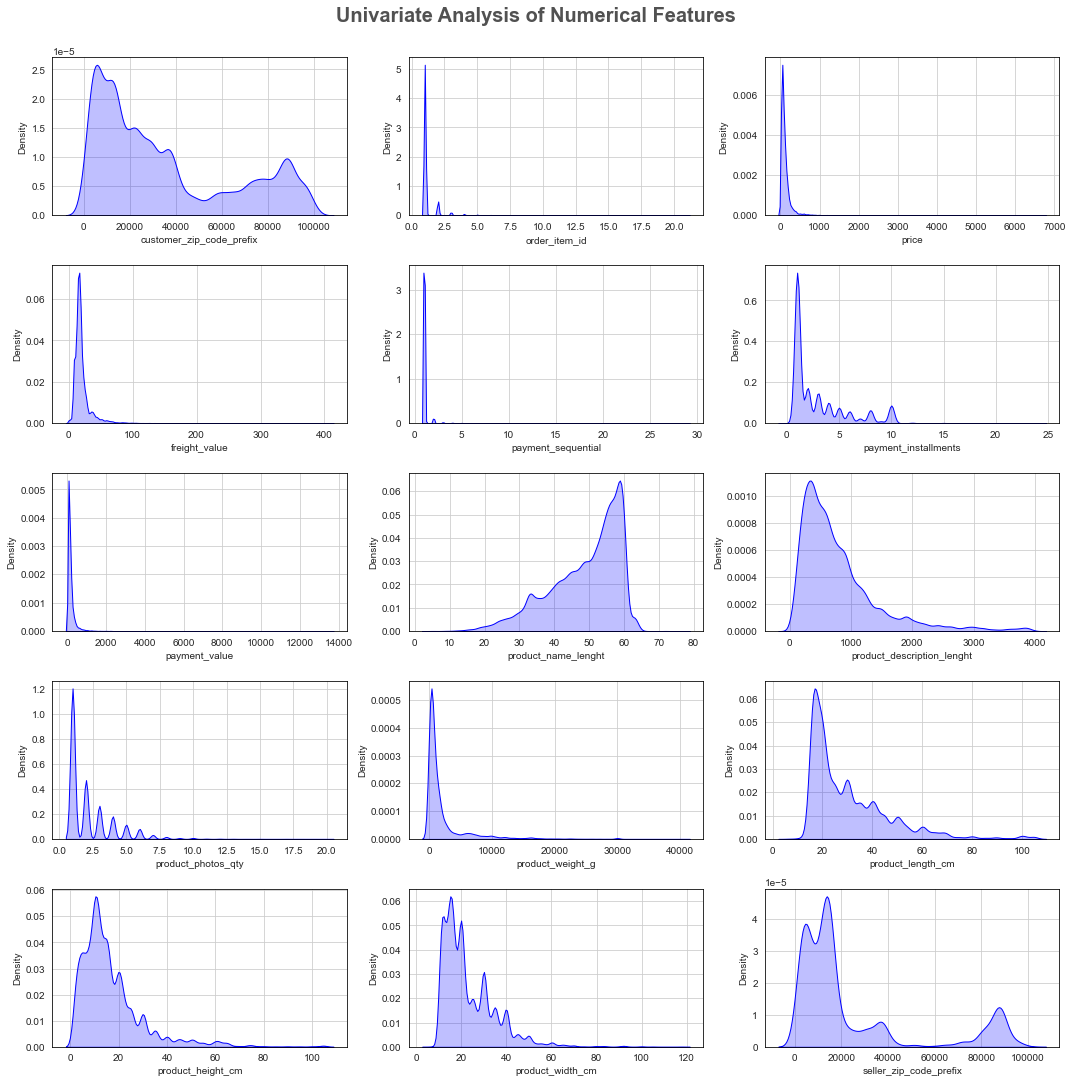

In [13]:
numeric_features = numeric_cols.columns

plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features',
             fontsize=20,
             fontweight='bold',
             alpha=0.8,
             y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(5, 3, i+1)
    sns.kdeplot(x=df[numeric_features[i]], shade=True, color="b")
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

Numerical features are skewed.

# Univariate analysis: categorical features

In [14]:
(df[categorical_cols]
 .describe()
 .T)

,count,unique,top,freq
customer_city,115878,4095,sao paulo,18277
customer_id,115878,97255,270c23a11d024a44c896d1894b261a83,63
customer_state,115878,27,SP,48838
customer_unique_id,115878,94087,9a736b248f67d166d2fbb006bcb877c3,75
order_id,115878,97255,895ab968e7bb0d5659d16cd74cd1650c,63
order_status,115878,7,delivered,113384
payment_type,115878,4,credit_card,85523
product_category_name,115878,71,cama_mesa_banho,11823
product_category_name_english,115878,71,bed_bath_table,11823
product_id,115878,32328,aca2eb7d00ea1a7b8ebd4e68314663af,536


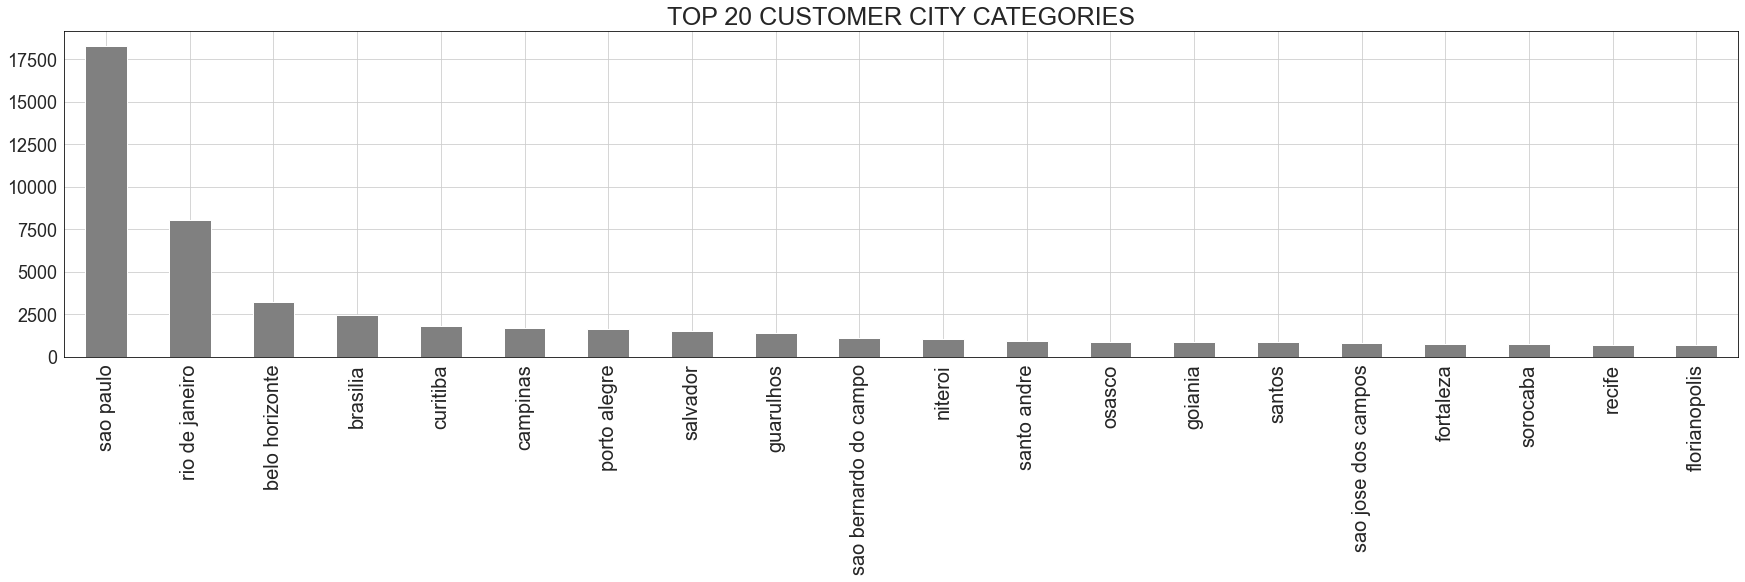

In [15]:
#Top 20 customer city sales.
plt.figure(figsize=(30,6))
df["customer_city"].value_counts().head(20).plot(kind="bar", color="grey")
plt.title("TOP 20 CUSTOMER CITY CATEGORIES", fontsize=25)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 20);

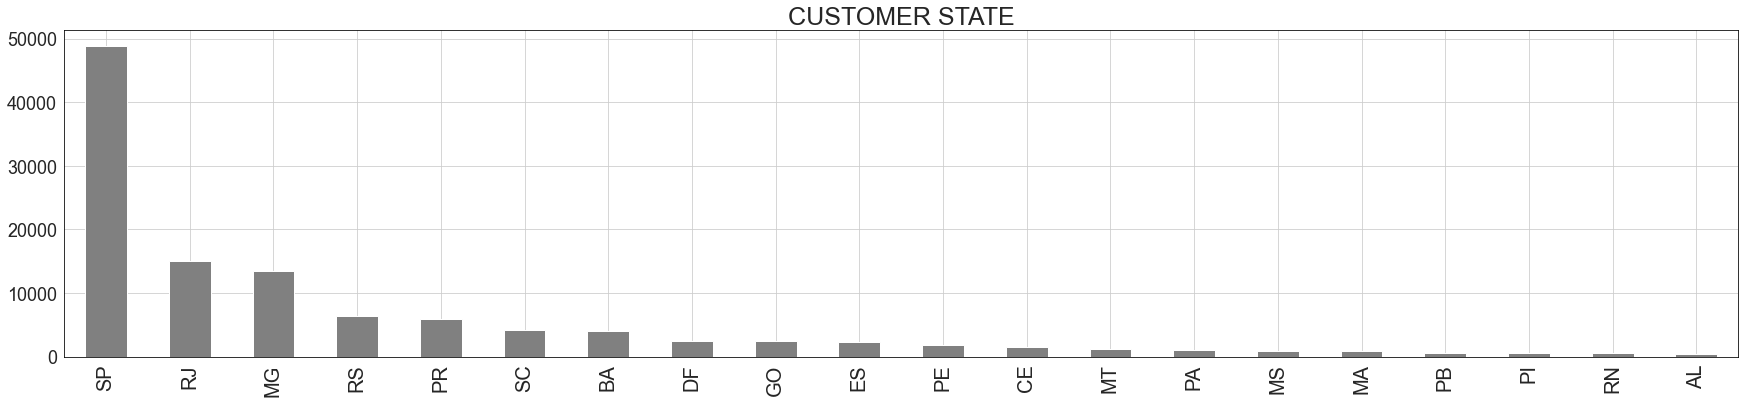

In [16]:
#Customer states sales.
plt.figure(figsize=(30,6))
df["customer_state"].value_counts().head(20).plot(kind="bar", color="grey")
plt.title("CUSTOMER STATE", fontsize=25)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 20);

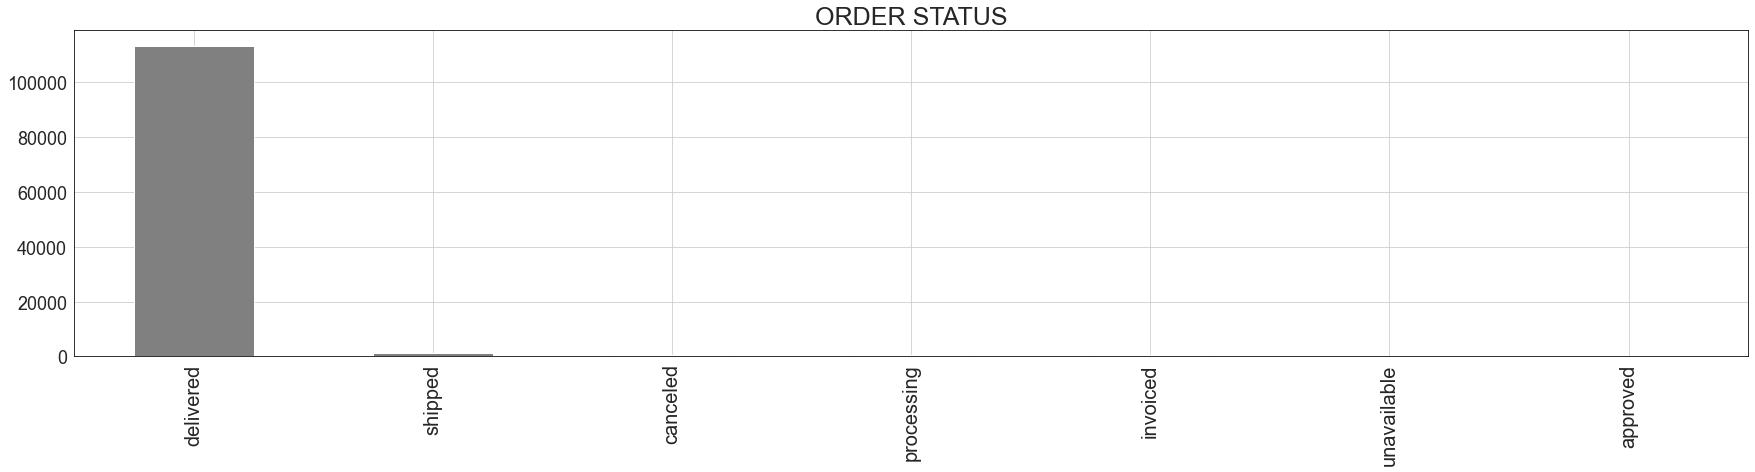

In [17]:
#Order status.
plt.figure(figsize=(30,6))
df["order_status"].value_counts().head(20).plot(kind="bar", color="grey")
plt.title("ORDER STATUS", fontsize=25)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 20);

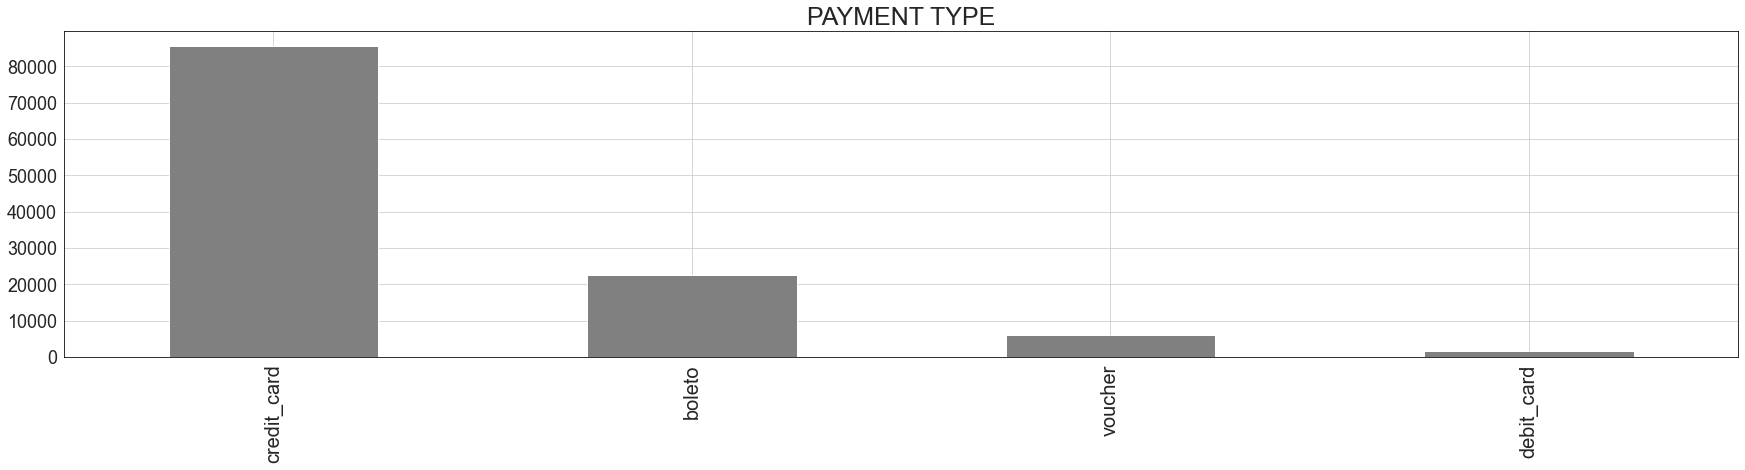

In [18]:
#Payment types.
plt.figure(figsize=(30,6))
df["payment_type"].value_counts().head(20).plot(kind="bar", color="grey")
plt.title("PAYMENT TYPE", fontsize=25)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 20);

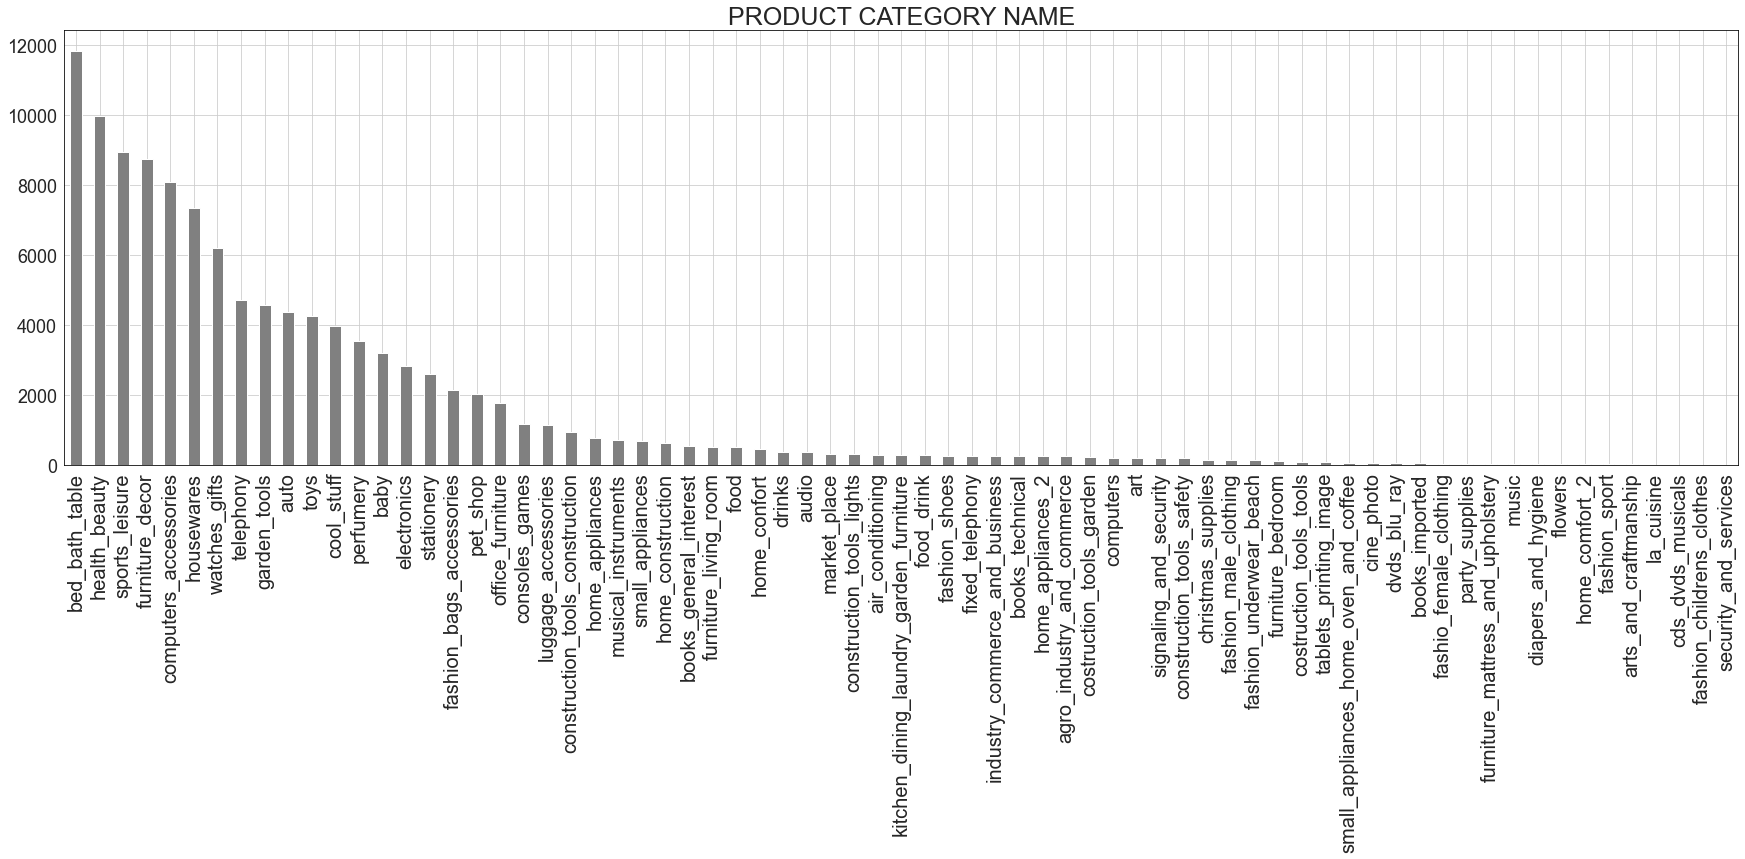

In [19]:
#Product categories sold.
plt.figure(figsize=(30,8))
df["product_category_name_english"].value_counts().plot(kind="bar", color="grey")
plt.title("PRODUCT CATEGORY NAME", fontsize=25)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 20);

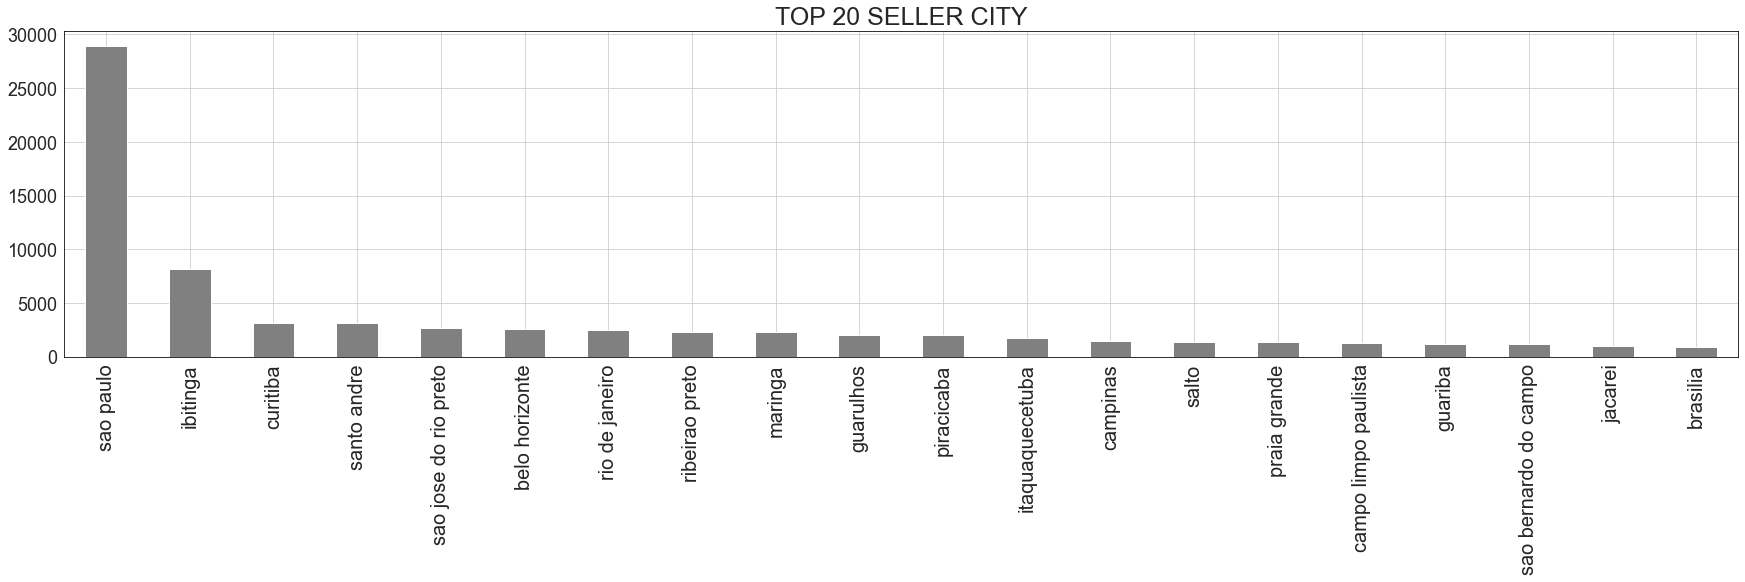

In [20]:
#Top 20 city sales.
plt.figure(figsize=(30,6))
df["seller_city"].value_counts().head(20).plot(kind="bar", color="grey")
plt.title("TOP 20 SELLER CITY", fontsize=25)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 20);

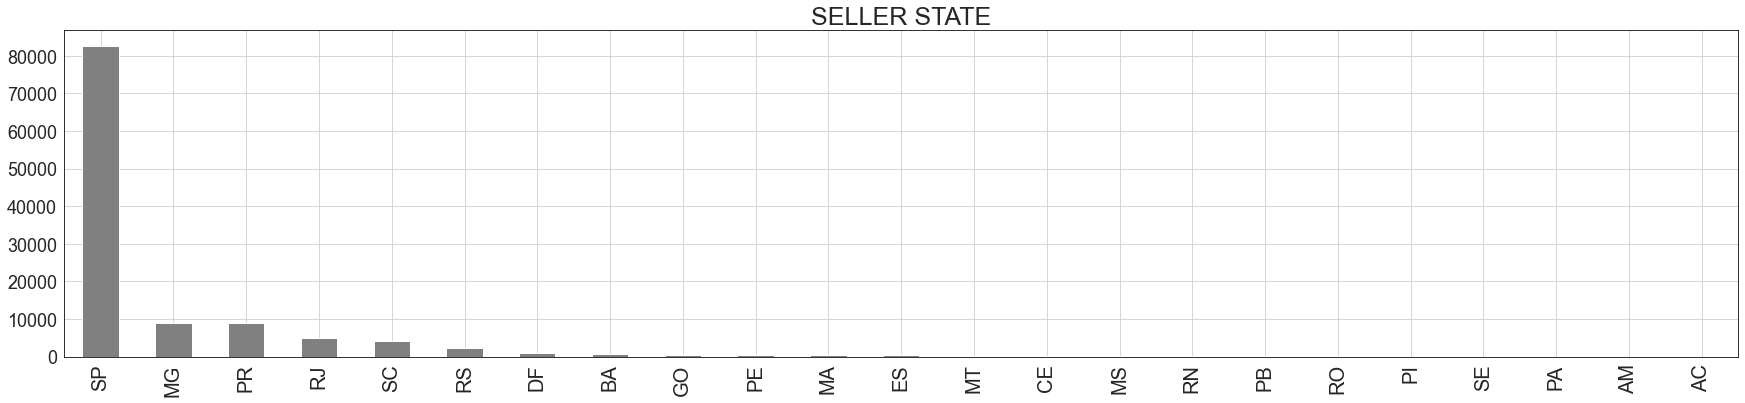

In [21]:
#Seller states.
plt.figure(figsize=(30,6))
df["seller_state"].value_counts().plot(kind="bar", color="grey")
plt.title("SELLER STATE", fontsize=25)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 20);

# Bivariate analysis numerical features

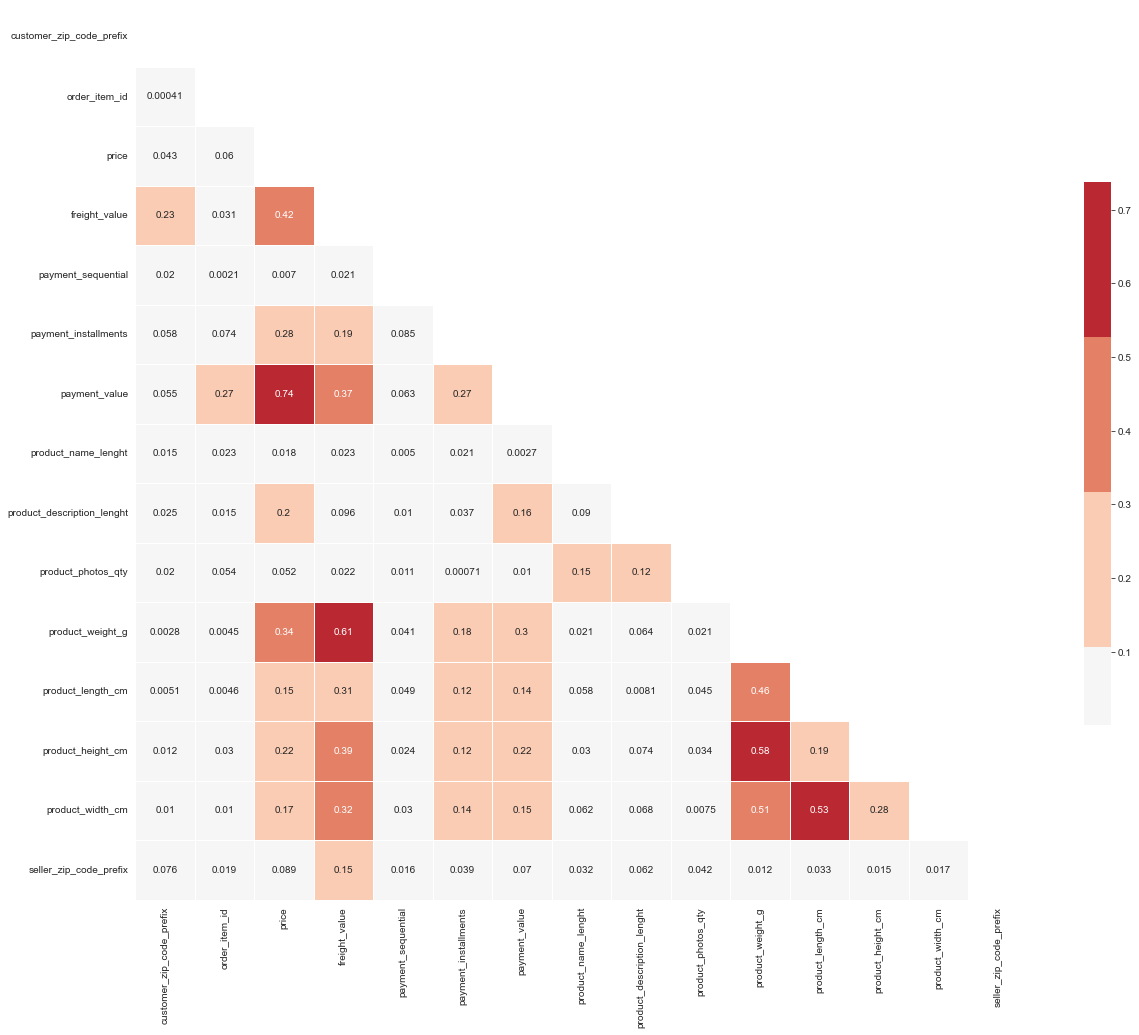

In [22]:
#Plotting Correlation map to identify numerical attributes relationships
correlation = numeric_cols.corr(method="pearson").abs()

mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlation, 
            mask=mask, 
            center=0,
            square=True, 
            annot=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            cmap=sns.color_palette("RdBu_r", 7))
plt.show()

features with strongest correlation:
- payment value and price
- product weight g and freight value
- product height cm and product weight g
- product width cm and product lenght cm

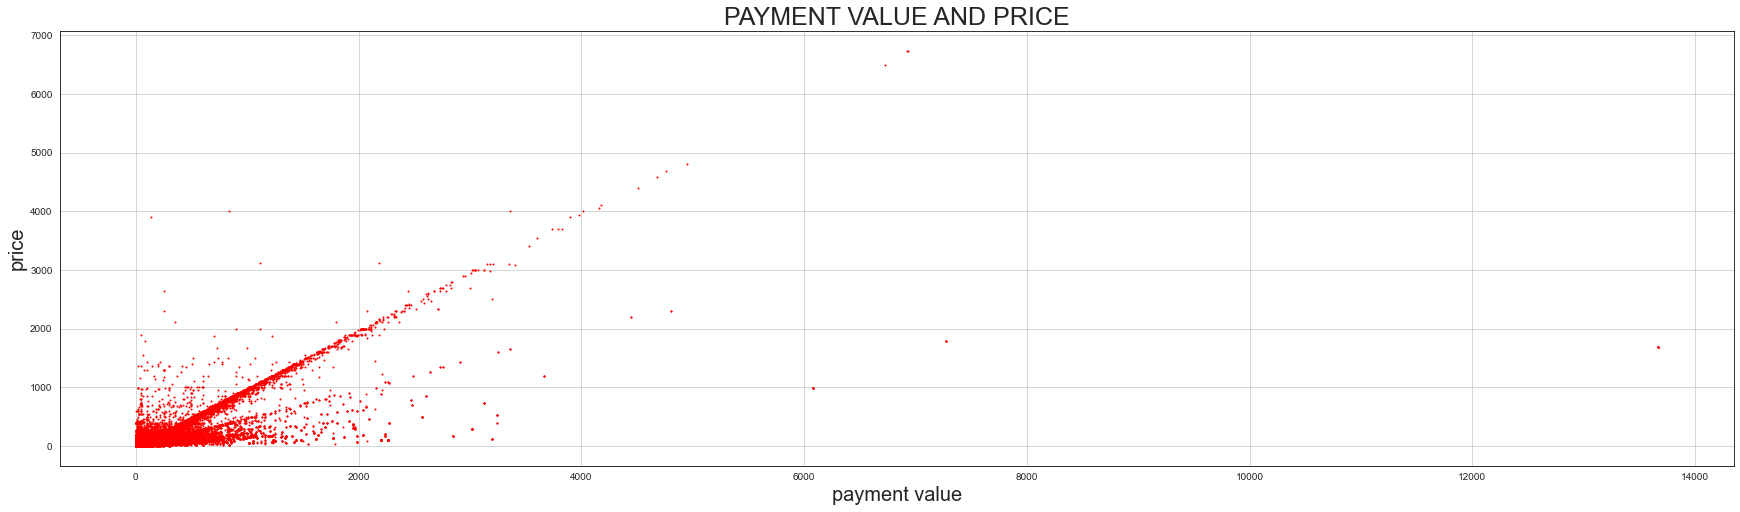

In [23]:
figure = plt.figure(figsize=(30,8))
ax = plt.axes() 
ax.plot(df["payment_value"], df["price"],marker="o", ls="", ms=1, color="red") 
ax.set(xlabel="payment value", ylabel="price")
plt.title("PAYMENT VALUE AND PRICE", fontsize=25) 
ax.xaxis.label.set_size(20);
ax.yaxis.label.set_size(20);

Payment value is the price of the product and something else (eg: shipping prices, and it depends of the weight and distance)

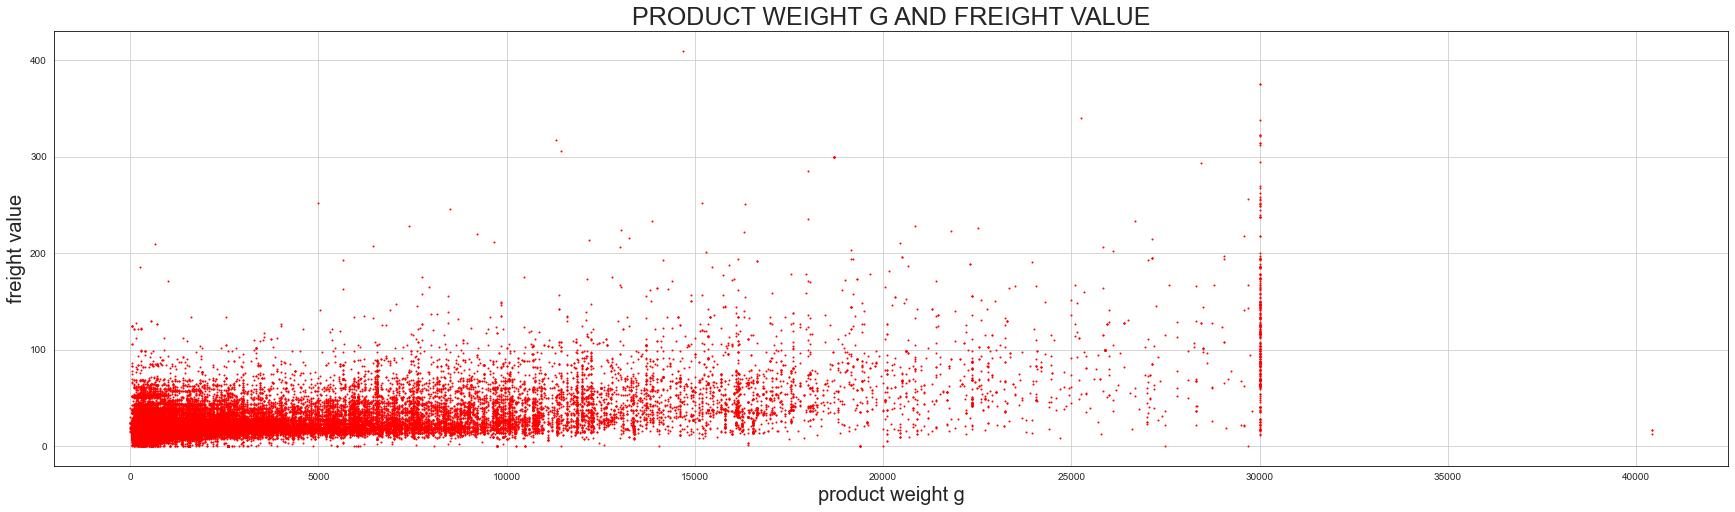

In [24]:
figure = plt.figure(figsize=(30,8))
ax = plt.axes() 
ax.plot(df["product_weight_g"], df["freight_value"],marker="o", ls="", ms=1, color="red") 
ax.set(xlabel="product weight g", ylabel="freight value")
plt.title("PRODUCT WEIGHT G AND FREIGHT VALUE", fontsize=25) 
ax.xaxis.label.set_size(20);
ax.yaxis.label.set_size(20);

more weight more freight value.

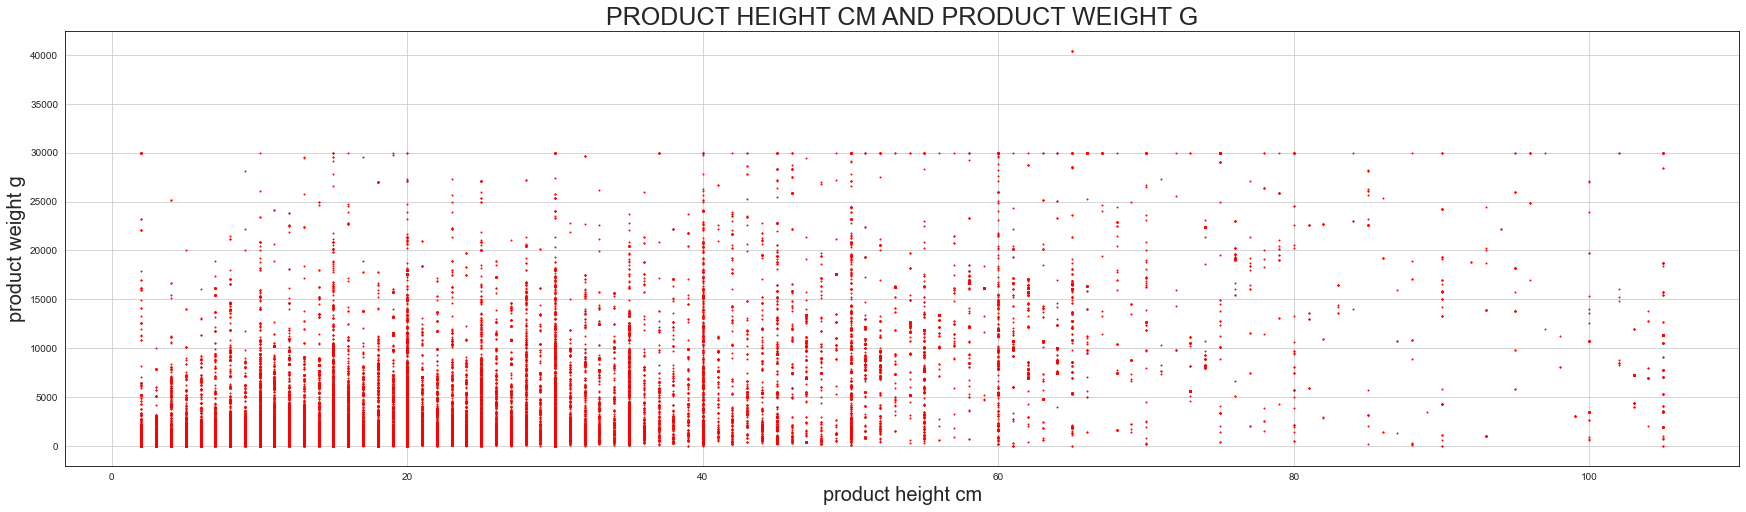

In [25]:
figure = plt.figure(figsize=(30,8))
ax = plt.axes() 
ax.plot(df["product_height_cm"], df["product_weight_g"],marker="o", ls="", ms=1, color="red") 
ax.set(xlabel="product height cm", ylabel="product weight g")
plt.title("PRODUCT HEIGHT CM AND PRODUCT WEIGHT G", fontsize=25) 
ax.xaxis.label.set_size(20);
ax.yaxis.label.set_size(20);

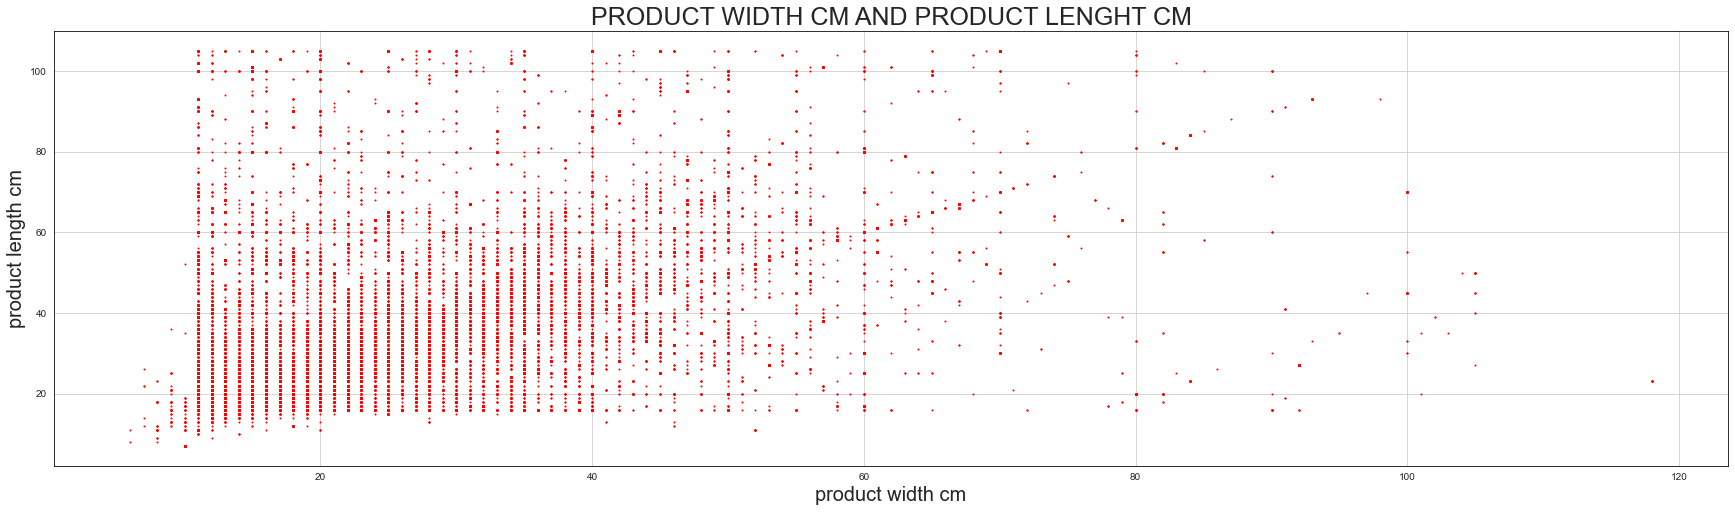

In [26]:
figure = plt.figure(figsize=(30,8))
ax = plt.axes() 
ax.plot(df["product_width_cm"], df["product_length_cm"],marker="o", ls="", ms=1, color="red") 
ax.set(xlabel="product width cm", ylabel="product length cm")
plt.title("PRODUCT WIDTH CM AND PRODUCT LENGHT CM", fontsize=25) 
ax.xaxis.label.set_size(20);
ax.yaxis.label.set_size(20);

# Bivariate analysis categorical features

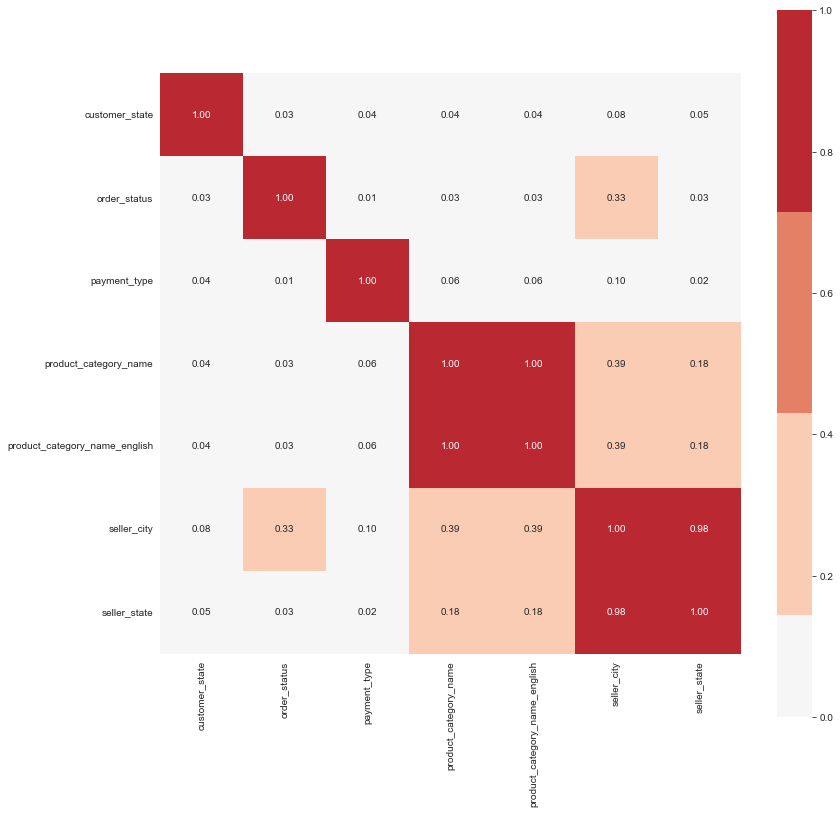

In [27]:
#Plotting Correlation map to identify categorical attributes relationships
drop = ["customer_city", "customer_id", "customer_unique_id", "order_id", "product_id", "seller_id"]
new_list = [e for e in categorical_cols if e not in drop]
categorical_df = df[new_list]

categorical_correlation= associations(categorical_df, 
                                      filename= "categorical_correlation.png", 
                                      figsize=(13,13),
                                      cmap=sns.color_palette("RdBu_r", 7))

features with strongest correlation:
- product category name english and product category name
- seller state and seller city

*Product category name english and product category name have the same categories but in different lenguages

# 4. PREPROCESSING

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [29]:
cols = ["customer_state","order_purchase_timestamp","order_item_id",
        "price","payment_sequential","payment_type","payment_installments",
        "payment_value","product_category_name_english","seller_state"]

df = df[cols]

In [30]:
def preprocessDates(df):    
    #order as datetime
    df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
    #new column "year"
    df["year"] = df["order_purchase_timestamp"].dt.year
    #new column "month"
    df["month"] = df["order_purchase_timestamp"].dt.month
    #new column "dayoftheweek"
    df["dayofweek"] = df["order_purchase_timestamp"].dt.dayofweek
    #new column "hour"
    df["hour"] = df["order_purchase_timestamp"].dt.hour
    #drop "order_purcharse_timestamp"
    df.drop("order_purchase_timestamp", axis=1, inplace=True)
    return df

df = preprocessDates(df)

In [31]:
numerical_cols = list(df.select_dtypes(include="number"))
categorical_cols = list(df.select_dtypes(include="object"))

In [32]:
#replace the rare categories (<0.05) with "Other"
def lowVarianceFunction(x):
    for col in x.columns:
            x[col] = x[col].mask(x[col].map(x[col].value_counts(normalize=True)) < 0.05, "Other")
            return x
        
df[categorical_cols] = lowVarianceFunction(df[categorical_cols])

In [33]:
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessing = ColumnTransformer([
    ("categorical", categorical_pipeline, categorical_cols),
    ("numerical", numerical_pipeline, numerical_cols)
])

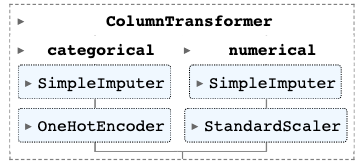

# 5. CLUSTERING 

(for numerical and categorical features)

In [34]:
#Im going to work with a sample, because the original df is too big.
rows = np.random.choice(df.index.values, 10000)
sample = df.loc[rows]
X_mix = preprocessing.fit_transform(sample)

# K - MEANS

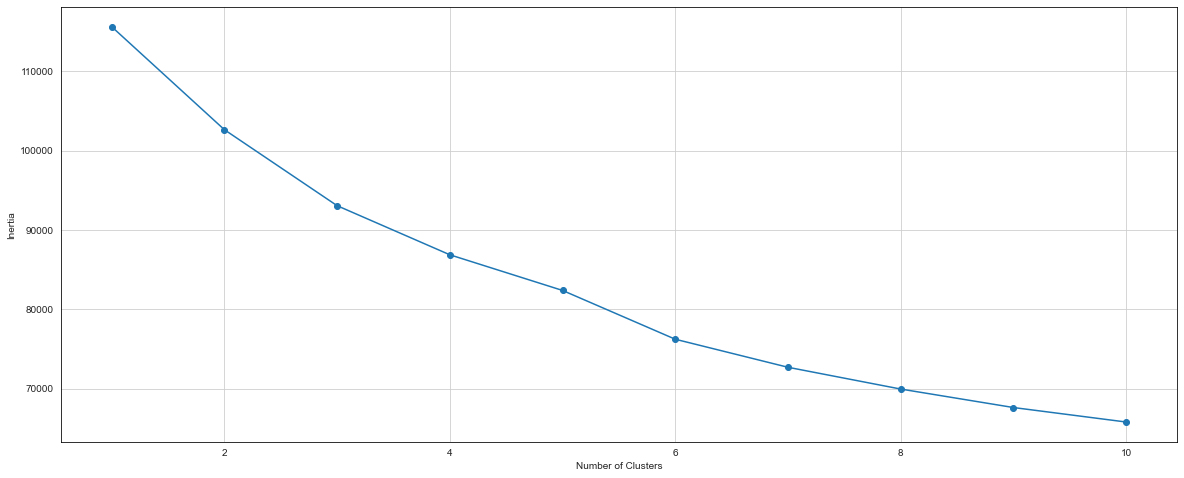

In [43]:
from sklearn.cluster import KMeans

inertia = []
list_num_clusters = list(range(1,11)) 
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X_mix)
    inertia.append(km.inertia_)
    
plt.figure(figsize=(20,8))    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia");

elbow: 5

In [44]:
#5 clusters
km = KMeans(n_clusters=5)
km.fit(X_mix)
y = km.predict(X_mix)
sample["k-means"] = y

In [45]:
# only for numerical features (used in agglomerative clustering and DBSCAN)
X_numerical = numerical_pipeline.fit_transform(sample[numerical_cols])

# AGGLOMERATIVE

In [46]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

ag = AgglomerativeClustering(n_clusters=5, 
                             linkage="ward")
ag = ag.fit(X_numerical)
agglomerative = ag.labels_
sample["agglomerative"] = agglomerative

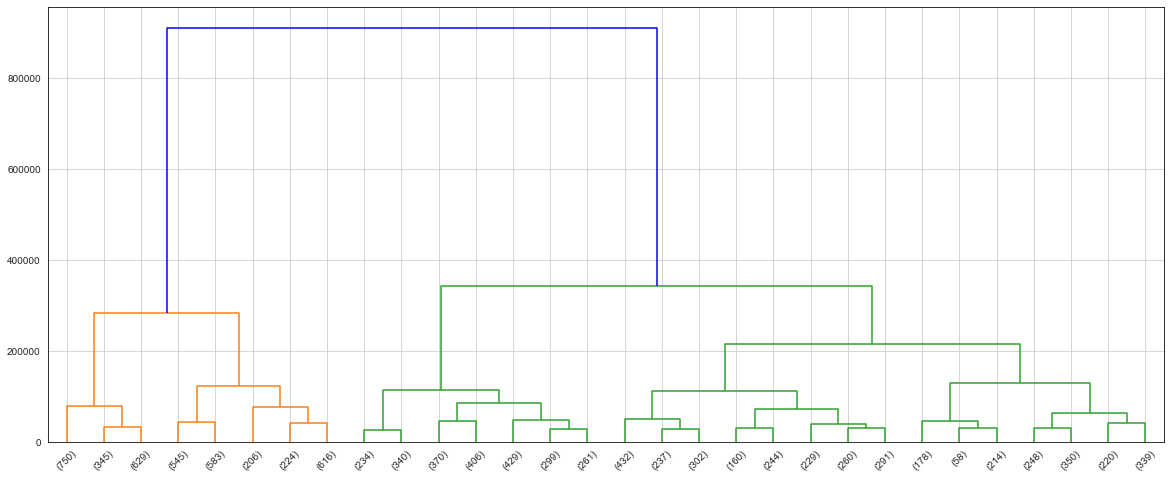

In [47]:
Z = hierarchy.linkage(ag.children_, method="ward")
fig, ax = plt.subplots(figsize=(20,8))
den = hierarchy.dendrogram(Z, 
                           orientation="top", 
                           p=30, 
                           truncate_mode="lastp",
                           show_leaf_counts=True, 
                           ax=ax,
                           above_threshold_color="blue")

# DBSCAN

In [48]:
from sklearn.cluster import DBSCAN

#There are two parameters in DBSCAN: min_samples and eps. 

dbs = DBSCAN(eps=1.5, 
             min_samples=3, 
             metric="euclidean")

sample["DBSCAN"] = dbs.fit_predict(X_numerical)

# LABELS:

In [49]:
sample[["k-means", "agglomerative", "DBSCAN"]].head(10)

,k-means,agglomerative,DBSCAN
33465,4,1,0
23942,1,1,0
53853,2,2,1
4128,1,1,0
64184,1,1,0
85661,2,2,1
7966,4,1,0
25085,2,2,1
75798,1,1,2
8312,4,1,0


The number of labels are different, but there seems to be some relationship when choosing which observations to group.